# 자전거 대여 수요 예측
* 캐글의 자전거 대여 수요 예측을 선형회귀와 트리 기반 회귀로 비교
* [캐글데이터 참조](https://www.kaggle.com/c/bike-sharing-demand/data/)

### 변수에 대한 설명
- datetime : hourly date  + timestamp
- season : 1 (봄), 2(여름), 3(가을), 4(겨울)
_ holiday : 1(토,일요일의 주말을 제외한 국경일등의 휴일) , 0(휴일이 아닌 날)
- workingday : 1(토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일)
- weather:
  * 1 : 맑음,약간 구릅 낀 흐림
  * 2 : 안개, 안계 + 흐림
  * 3 : 가벼운 눈, 가벼운 비 + 천둥
  * 4 : 심한 눈/비 , 천둥/번개
- temp : 온도(섭씨)
- atemp : 체감온도(섭씨)
- humidity :  상대습도
- windspeed : 풍속
- casual : 사전에 등록되지 않는 사용자가 대여한 횟수
- registered : 사전에 등록된 사용자가 대여한 횟수
- count : 대여횟수 

### 데이터 클랜징 및 가공

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore', category = RuntimeWarning)

from IPython.display import Image

In [2]:
bike_df = pd.read_csv("../../08.Kaggle_Dacon/data/bike-sharing-demand/bike_train.csv")
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


**datetime 피처의 가공**

In [4]:
bike_df['datetime'] = bike_df["datetime"].apply(pd.to_datetime)

In [5]:
bike_df['year'] = bike_df["datetime"].apply(lambda x: x.year)
bike_df['month'] = bike_df["datetime"].apply(lambda x: x.month)
bike_df['day'] = bike_df["datetime"].apply(lambda x: x.day)
bike_df['hour'] = bike_df["datetime"].apply(lambda x: x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


**불필요한 피처 삭제**

In [6]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(labels = drop_columns, axis = 1, inplace = True)

In [7]:
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


### 다양한 회귀모델을 데이터세트에 적용해 예측성능 측정

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#로그값 변환 시 NaN등의 이슈로 log()가 아닌 log1p()이용해 RSMLE계산
def rmsle(y, pred):
    """
    Description : RSMLE(Root Squared Mean Square Log Error)를 계산
    Parameter : y - label값, pred - 예측값    
    """
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def  rmse(y, pred):
    """
    사이킷런의 mean_squared_error()를 이용해 RMSE계산
    """
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_repr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val  = rmse(y,pred)
    
    # MAE는 사이킷런의 mean_abolute_error로 계산
    mae_val = mean_absolute_error(y, pred)
    print("RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE: {2:.3f}".format(rmsle_val, rmse_val, mae_val))

In [9]:
#def rmsle(y, pred):
#    """
#    이와 같이 mean_squared_log_error()제공하는 함수를 이용하는 경우엔 
#    오버플로우 혹은 언더플로우 에러가 날 수 있음에 유의할것.
#    """
 #   msle = mean_squared_log_error(y, pred)
 #   rmsle = np.sqrt(msle)
 #   return rmsle

### 로그 변환, 피처 인코딩과 모델 학습/예측 평가
* 회귀모델을 적용하기 전에 데이터세트에 전처리 작업이 필요하다.
* **결과값이 정규분포로 되어 있는지 확인하는 것과 카테고리형 회귀 모델의 원-핫 인코딩으로 피처를 인코딩하는것**

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = .3, random_state = 0)
lr_reg = LinearRegression()

lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_repr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE: 105.924


**실제값과 예측치의 차이 비교**

In [11]:
def get_top_error_data(y_test, pred, n_top = 5):
    """
    실제 값과 예측값을 인자로 받아 그 차이를 같이 보여주는 기능
    인자 : y_test(실제 레이블값), pred(예측값), n_top - TOP 5
    """
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 살제값이 가장 큰 TOP 5를 출력
    print(result_df.sort_values(by = 'diff', ascending = False)[:n_top])
get_top_error_data(y_test, pred, n_top = 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


실무에서 이렇게 큰 예측오류가 나올때 살펴보아야 할것은 무엇일까?

**Target값의 분포가 왜곡된 형태를 이루고있지는 않는지 확인**하는것이 일차적으로 필요.

타겟값의 **히스토그램**을 확인

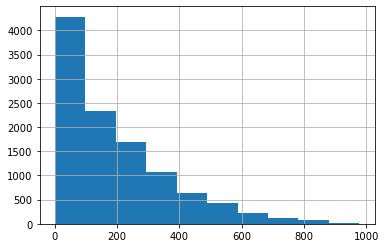

In [12]:
y_target.hist()

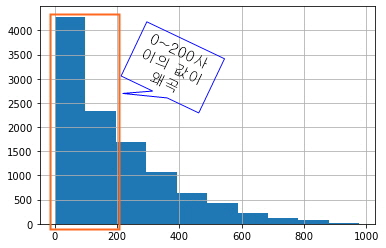

In [13]:
Image("../../img/왜곡1포맷변환_.png") 

In [14]:
# log1p()로 변환해보자.
y_log_transfrom  = np.log1p(y_target)

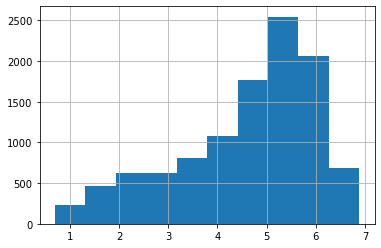

In [15]:
# 변환이후의 분포
y_log_transfrom.hist()

In [16]:
# 학습 후 평가 재수행
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target_log = np.log1p(y_target)
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = .3, random_state = 0)
lr_reg = LinearRegression()

lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)


# 테스트 데이터 세트의 Target값은 로그 변환되었으므로 다시 expm1을 이용해 원레 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타겟 기반으로 학습돼 예측되었으므로 다시 expm1로 스케일변환
pred_exp = np.expm1(pred)

evaluate_repr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE: 109.286


In [17]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)

coef_sort.index

Index(['year', 'hour', 'month', 'atemp', 'temp', 'windspeed', 'day',
       'humidity', 'weather', 'season', 'holiday', 'workingday'],
      dtype='object')

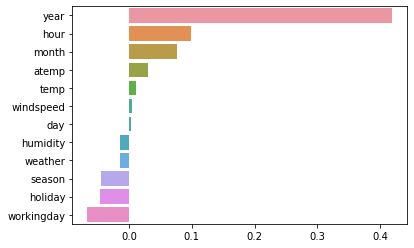

In [18]:
sns.barplot(x = coef_sort.values, y = coef_sort.index)

In [19]:
# 카테고리형 피처를 원-핫 인코딩해보자.
X_features_ohe = ['year', 'hour', 'month', 'day', 'weather', 'season', 'holiday', 'workingday']

ohe_result_X = pd.get_dummies(X_features, columns = X_features_ohe)
ohe_result_X

,temp,atemp,humidity,windspeed,year_2011,year_2012,hour_0,hour_1,hour_2,hour_3,...,weather_3,weather_4,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1
0,9.84,14.395,81,0.0000,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,9.02,13.635,80,0.0000,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,9.02,13.635,80,0.0000,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
3,9.84,14.395,75,0.0000,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
4,9.84,14.395,75,0.0000,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
10882,14.76,17.425,57,15.0013,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
10883,13.94,15.910,61,15.0013,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
10884,13.94,17.425,61,6.0032,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


In [20]:
# 원-핫인코딩이 적용딘 피처 데이터세트를 기반으로 학습/예측 수행
X_train, X_test, y_train, y_test = train_test_split(ohe_result_X, y_target_log, test_size = .3, random_state = 0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    """
    Descrption : 모델, 분리된 학습/테스트세트, 역변환 유무 인자를 입력받아 모델에 대해 수행된 예측의 성능 평가
    """
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print("### ", model.__class__.__name__, " ###")
    evaluate_repr(y_test, pred)
    
    # 실제값과 예측치 차이
    get_top_error_data(y_test, pred, n_top = 25)
    
# 모델별 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 10)  # 왜 10일까?
lasso_reg = Lasso(alpha = 0.01) # 왜 .01

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

###  LinearRegression  ###
RMSLE : 0.590, RMSE : 97.687, MAE: 63.382
###  Ridge  ###
RMSLE : 0.590, RMSE : 98.529, MAE: 63.893
###  Lasso  ###
RMSLE : 0.635, RMSE : 113.219, MAE: 72.803


**원-핫 인코딩으로 회귀계수가 늘어났으므로 상위 25개 피처 추출해 시각화**

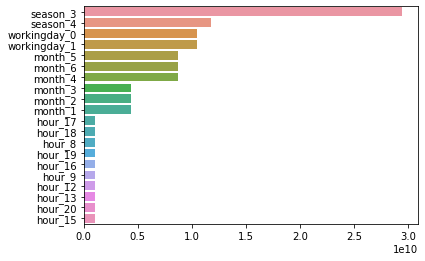

In [21]:
coef = pd.Series(lr_reg.coef_, index = ohe_result_X.columns)
coef_sort = coef.sort_values(ascending = False)[:20]
sns.barplot(x = coef_sort.values, y = coef_sort.index)

**회귀트리를 이용해 회귀 예측 수행**
* 랜덤포레스트, GBM, XGBoost, LightGBM 성능 평가

In [27]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [31]:
# 랜덤포레스트, GBM, XGBoost, LightGBM별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimators = 500)
lgbm_reg = LGBMRegressor(n_estimators = 500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    #XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능.
    # ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

###  RandomForestRegressor  ###
RMSLE : 0.354, RMSE : 50.331, MAE: 31.123
###  GradientBoostingRegressor  ###
RMSLE : 0.330, RMSE : 53.333, MAE: 32.743
###  XGBRegressor  ###
RMSLE : 0.342, RMSE : 51.709, MAE: 31.240
###  LGBMRegressor  ###
RMSLE : 0.319, RMSE : 47.215, MAE: 29.029
